In [1]:
import numpy as np
import matplotlib.pyplot as plt



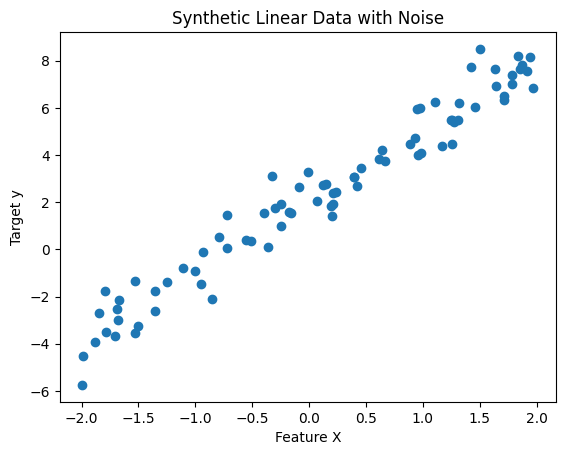

In [2]:

rng = np.random.default_rng(13)

n=80
X = rng.uniform(-2.0, 2.0, size=(n,1)) 
#Creates the input feature matrix X by sampling from a uniform distribution. 
# Each value is between -2 and 2 size=(n, 1) means: make it a 2D array with: 
# n rows (samples)
# 1 column (one feature)
# Shape is (80, 1)
# Why (n,1) and not (n,)?
# Because in ML we treat features as matrices. This makes matrix math consistent later.

true_w = 3.0 #The “true” slope of the underlying relationship (ground truth).
true_b = 2.0 #The “true” intercept (bias term).

noise = rng.normal(0, 0.8, size=(n,1)) # Gaussian noise (mean=0, std=0.8) to add variability to the data. same shape as X
y = true_w * X + true_b + noise # Linear relationship with noise. true_w * X + true_b is the linear function, noise adds randomness.
# y is the target variable (output) corresponding to each input in X.
# Shape of y is also (80, 1). elementwise multiplication and addition.
# So we have 80 samples of (X, y) pairs.

plt.scatter(X[:, 0], y[:, 0])
plt.xlabel("Feature X")
plt.ylabel("Target y")
plt.title("Synthetic Linear Data with Noise")
plt.show()


In [3]:
# Add a column of ones for the intercept (bias)
X_design = np.hstack([np.ones((n, 1)), X])   # shape (n, 2), hstack creates horizontal stack
# First column is all ones (for intercept - bias), second column is the feature X.
print   (X_design[:5])  # Print first 5 rows to verify

[[ 1.          1.45919035]
 [ 1.          1.42121006]
 [ 1.          1.2440936 ]
 [ 1.         -0.95421455]
 [ 1.         -1.69120217]]


**Closed-form least squares (two ways)**

The closed-form solution (normal equation) is:

$$
\boldsymbol{\theta} = (X^\top X)^{-1} X^\top \mathbf{y}
$$

Here, `X_design` is the design matrix with a column of ones for the intercept and the feature column. Computing this in NumPy matches the implementation below:

`theta_ne = np.linalg.inv(X_design.T @ X_design) @ (X_design.T @ y)`

In [4]:
# Option A: stable way
theta_lstsq, *_ = np.linalg.lstsq(X_design, y, rcond=None)  # shape (2,1) because θ has 2 parameters (intercept and slope)
# lstsq returns multiple outputs (solution, residuals, rank, singular values).
# We only care about the first one (the solution), so we grab it into theta_lstsq and ignore the rest with *_.
# rcond=None uses the default cutoff for small singular values.

# Option B: normal equation (may be less stable in big problems, but great for learning)

theta_ne = np.linalg.inv(X_design.T @ X_design) @ (X_design.T @ y)
#full formula: θ = (X^T * X)^(-1) * X^T * y

theta_lstsq, theta_ne


(array([[2.05386167],
        [2.96489789]]),
 array([[2.05386167],
        [2.96489789]]))

In [5]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_design shape:", X_design.shape)
print("theta_lstsq shape:", theta_lstsq.shape)


X shape: (80, 1)
y shape: (80, 1)
X_design shape: (80, 2)
theta_lstsq shape: (2, 1)


Estimated parameters from lstsq: intercept (b) = 2.05, slope (w) = 2.96


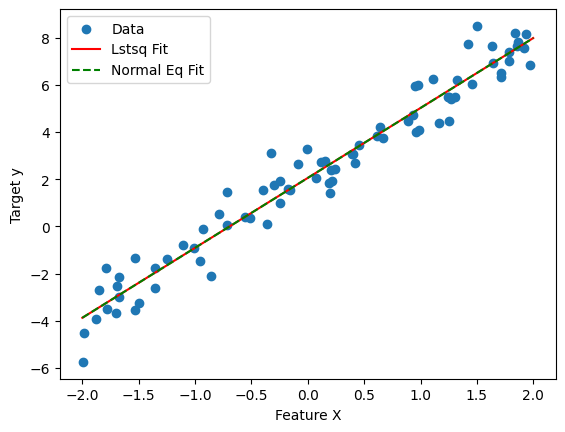

In [6]:
b_hat= theta_lstsq[0, 0]
w_hat= theta_lstsq[1, 0]
print(f"Estimated parameters from lstsq: intercept (b) = {b_hat:.2f}, slope (w) = {w_hat:.2f}")

plt.scatter(X[:, 0], y[:, 0], label="Data")
x_vals = np.array([-2, 2])  
y_vals_lstsq = theta_lstsq[0] + theta_lstsq[1] * x_vals
y_vals_ne = theta_ne[0] + theta_ne[1] * x_vals
plt.plot(x_vals, y_vals_lstsq, color='red', label='Lstsq Fit')
plt.plot(x_vals, y_vals_ne, color='green', linestyle='--', label='Normal Eq Fit')
plt.xlabel("Feature X")
plt.ylabel("Target y")
plt.legend()
plt.show()

### 1) The simplest model: a straight line

The schoolbook line is:

$$
y = w x + b
$$

- x: input (example: amount of sugar in grams)
- y: output (example: how much people like it, a score)
- w: slope ("how much y changes when x changes by 1")
- b: intercept ("what y is when x = 0")

Example:

If $w=3$ and $b=2$, then:

- when $x=0$, $y=2$
- when $x=1$, $y=5$
- when $x=2$, $y=8$

So the “true rule” is: multiply x by 3, then add 2.

---

### 2) Real life is noisy

Measurements are not perfect. Even if the true rule is $y=3x+2$, you might observe noise:

$$
y = 3x + 2 + \text{noise}
$$

Noise might be -0.7, +0.3, etc. For example, if $x=1$:

- true value: $3(1)+2 = 5$
- noise: say $-0.7$
- observed value: $5 - 0.7 = 4.3$

That’s exactly what we simulate in the code by adding Gaussian noise to $y$.

---

### What are we doing with synthetic data?

"Synthetic" means we create fake data ourselves where we know the ground-truth ($w=3$, $b=2$). This lets us check whether our method can recover those parameters. We:

- sample many $x$ values,
- compute $y$ using the line plus noise,
- plot the pairs and see a cloud of points around the underlying line.

---

### What does "least squares" mean (no linear algebra needed)

Goal: find $\,\hat w\,$ and $\,\hat b\,$ so the line $\hat y = \hat w x + \hat b$ best fits the points.

Step A — error for one point $(x_i, y_i)$:

$$
\hat y_i = \hat w x_i + \hat b,
\quad e_i = y_i - \hat y_i.
$$

Step B — square errors so negatives don't cancel positives:

$$
\text{(squared error)} = e_i^2
$$

Step C — sum (or average) squared errors (SSE):

$$
\text{SSE} = \sum_{i=1}^n \left(y_i - (\hat w x_i + \hat b)\right)^2
$$

Least squares: choose $\hat w,\hat b$ that minimize SSE — i.e., the line with the smallest total squared vertical distance to the points.

---

### Where matrix (linear algebra) enters — a compact view

Put the intercept and slope into a parameter vector $\boldsymbol{\theta} = [\hat b\; \hat w]^\top$ and the inputs into a design matrix:

$$
X_{\text{design}} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix},
\quad \boldsymbol{\hat y} = X_{\text{design}} \boldsymbol{\theta}.
$$

Example (3 points):

$$
X_{\text{design}} = \begin{bmatrix} 1 & -2 \\ 1 & 0 \\ 1 & 1 \end{bmatrix},
\quad \boldsymbol{\theta} = \begin{bmatrix} \hat b \\ \hat w \end{bmatrix}.
$$

This is just a compact way of writing the same set of equations for each point.

---

### The "closed-form solution"

There is a direct formula that gives the best parameters without search. In matrix form:

$$
\boldsymbol{\hat\theta} = (X^\top X)^{-1} X^\top \mathbf{y}.
$$

In NumPy you can compute the solution with `np.linalg.lstsq(X_design, y)` (recommended) or the normal equation `np.linalg.inv(X_design.T @ X_design) @ (X_design.T @ y)` (fine for small examples and for learning).

**Gradient descent**

### 1) What problem are we solving?

You have data points $(x_i, y_i)$. You want a line:

$$\hat{y} = wx + b$$

- $w$: slope
- $b$: intercept

For each data point, your model predicts:

$$\hat{y}_i = wx_i + b$$

But your observed $y_i$ isn't perfectly on the line (noise). So we need a notion of "best".

---

### 2) What does "best" mean? Loss function

Define the error for each point:

$$e_i = \hat{y}_i - y_i$$

We square errors and average them (so negatives don't cancel positives):

$$\text{MSE}(w,b) = \frac{1}{n}\sum_{i=1}^{n}(\hat{y}_i - y_i)^2 = \frac{1}{n}\sum_{i=1}^{n}(wx_i + b - y_i)^2$$

This is a single number: how bad the line is.

So the real goal is:

$$\min_{w,b} \text{MSE}(w,b)$$

That means: find $w, b$ where MSE is as small as possible.

---

### 3) The key idea of gradient descent (intuition)

Think of $\text{MSE}(w,b)$ as a landscape (a "surface") over the plane of parameters $(w,b)$.

Every point $(w,b)$ gives you a loss value.

The best $(w,b)$ is at the bottom of the valley.

Gradient descent is like standing on that surface blindfolded and feeling which direction goes most steeply up. That direction is the gradient.
So to go down, you step in the opposite direction.

Core update rule:

$$\theta \gets \theta - \alpha \nabla J(\theta)$$

- $\theta$ = parameters (here $\theta = [b, w]^T$)
- $J(\theta)$ = loss (MSE)
- $\nabla J(\theta)$ = gradient ("slope" in parameter space)
- $\alpha$ = learning rate (step size)

That's the whole algorithm.

---

### 4) Make it computer-friendly: vector/matrix form (your code)

Instead of writing $wx + b$ repeatedly, we build a matrix:

For each data point $x_i$, write:

$$\hat{y}_i = b \cdot 1 + w \cdot x_i$$

So each row becomes $[1, x_i]$. Stack rows:

$$X = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix}, \quad \theta = \begin{bmatrix} b \\ w \end{bmatrix}, \quad y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$$

Then predictions are:

$$\hat{y} = X\theta$$

This is exactly your code:

```python
y_pred = X_design @ theta
```

---

### 5) The math of the gradient (the "lecture derivation")

Define the loss:

$$J(\theta) = \frac{1}{n}\|X\theta - y\|^2$$

That means:

$$J(\theta) = \frac{1}{n}(X\theta - y)^T(X\theta - y)$$

Let $r = X\theta - y$ (residual vector). Then:

$$J(\theta) = \frac{1}{n}r^T r$$

Now the crucial result (you can memorize this for linear regression):

$$\nabla_\theta J(\theta) = \frac{2}{n}X^T(X\theta - y)$$

That's your code line:

```python
grad = (2.0 / n) * (X_design.T @ (y_pred - y))
```

**Why it makes sense intuitively:**

- $y_{\text{pred}} - y$ tells you "how wrong you are" for each data point.
- $X^T$ combines those errors to decide how to adjust each parameter ($b$ and $w$).
- The gradient returns a vector with 2 components: gradient for $b$ and gradient for $w$.

---

### 6) Update step (why subtract?)

Once you have the gradient:

$$\theta \gets \theta - \alpha \nabla J(\theta)$$

In code:

```python
theta = theta - lr * grad
```

- If the gradient for $w$ is positive, loss increases when $w$ increases → so you reduce $w$.
- If gradient is negative, increasing $w$ decreases loss → subtracting a negative increases $w$.
- So subtracting always moves you downhill.

---

### 7) A tiny numeric example (so it's not abstract)

Suppose you only have 2 points:

- $(x_1, y_1) = (0, 1)$
- $(x_2, y_2) = (1, 3)$

True line is $y = 2x + 1$.

Build:

$$X = \begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}, \quad y = \begin{bmatrix} 1 \\ 3 \end{bmatrix}$$

Start with $\theta_0 = [b, w]^T = [0, 0]^T$.

Predict:

$$\hat{y} = X\theta_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

Residuals:

$$r = \hat{y} - y = \begin{bmatrix} -1 \\ -3 \end{bmatrix}$$

Gradient:

$$\nabla J = \frac{2}{n}X^T r$$

Here $n=2$:

$$X^T = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}, \quad X^T r = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} -1 \\ -3 \end{bmatrix} = \begin{bmatrix} -4 \\ -3 \end{bmatrix}$$

So:

$$\nabla J = \frac{2}{2}\begin{bmatrix} -4 \\ -3 \end{bmatrix} = \begin{bmatrix} -4 \\ -3 \end{bmatrix}$$

Update with learning rate $\alpha = 0.1$:

$$\theta_1 = \theta_0 - 0.1 \nabla J = \begin{bmatrix} 0 \\ 0 \end{bmatrix} - 0.1 \begin{bmatrix} -4 \\ -3 \end{bmatrix} = \begin{bmatrix} 0.4 \\ 0.3 \end{bmatrix}$$

So after 1 step:

- $b$ increased to 0.4
- $w$ increased to 0.3

That's exactly what you'd expect: starting from 0, the algorithm moves toward the true $b=1, w=2$.

Repeat many steps → it converges.

---

### 8) What are lr, epochs, losses really?

**lr (learning rate $\alpha$):** How big each step is.
- Too large → you overshoot the valley and can diverge
- Too small → you crawl slowly

**epochs:** How many update steps you take.

**losses:** Your "convergence history", like residual norm in iterative solvers:
- You want it to go down and flatten

---

### 9) Why does it converge for linear regression?

For MSE + linear model, the loss surface is a bowl-shaped quadratic in $(b,w)$.
A bowl has one global minimum—no local traps. So gradient descent (with a reasonable lr) will move toward the unique best solution.

That's also why your closed-form solution exists.

---

### 10) How you debug gradient descent like a pro

**If loss goes up or becomes nan:**
- lr too big → reduce lr (e.g., 0.05 → 0.01)

**If loss decreases but very slowly:**
- Increase epochs or slightly increase lr

**If theta shapes break:**
- Confirm shapes:
  - `X_design` is (n, 2)
  - `theta` is (2, 1)
  - `y` is (n, 1)

**Connect back to your exact code (one sentence per line):**

```python
y_pred = X_design @ theta                    # predict using current b,w
loss = mse(y, y_pred)                        # measure "badness"
grad = (2/n) * X_design.T @ (y_pred - y)     # compute slope of loss wrt b,w
theta = theta - lr * grad                    # move downhill
```

That's gradient descent.


In [ ]:
def mse(y_true, y_pred):
    return float(np.mean((y_true - y_pred) ** 2))

theta = np.zeros((2, 1))

lr = 0.05
epochs = 400
losses = []

for t in range(epochs):
    y_pred = X_design @ theta
    loss = mse(y, y_pred)
    losses.append(loss)

    grad = (2.0 / n) * (X_design.T @ (y_pred - y))
    theta = theta - lr * grad

theta, losses[0], losses[-1]